## the general difference between edge detectors <br/>
- sobel: <br/>
used for detecting edges in an image with high contrast. <br/>
- canny: <br/>
used for detecting edges with very low noise. <br/> 
- prewitt: <br/>
used for detecting edges in an image with low contrast. <br/>
- Robert: <br/>
used for detecting diagonal edges.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy import ndimage


In [3]:
# Parameters to be tuned in different functions
LOW_THRESHOLD_RATIO = 0.09
HIGH_THRESHOLD_RATIO = 0.17
WEAK_PIXEL = 100
STRONG_PIXEL = 255

SAMPLE_IMAGE = "Images/img3.jpg"


In [4]:
# A few utility functions to preprocess and visualize the results
# edge detection algorithms are based on grayscale images, so it's a pre-requist to convert the input image into grayscale
def rgb2gray(rgb):
    """
        Converts an RGB image into grayscale
    """
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

# visualizing function
def visualize(imgs, m, n):
    """
        Visualize images with the matplotlib library
    """
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(m, n, plt_idx)
        plt.imshow(img, cmap='gray')
    plt.show()


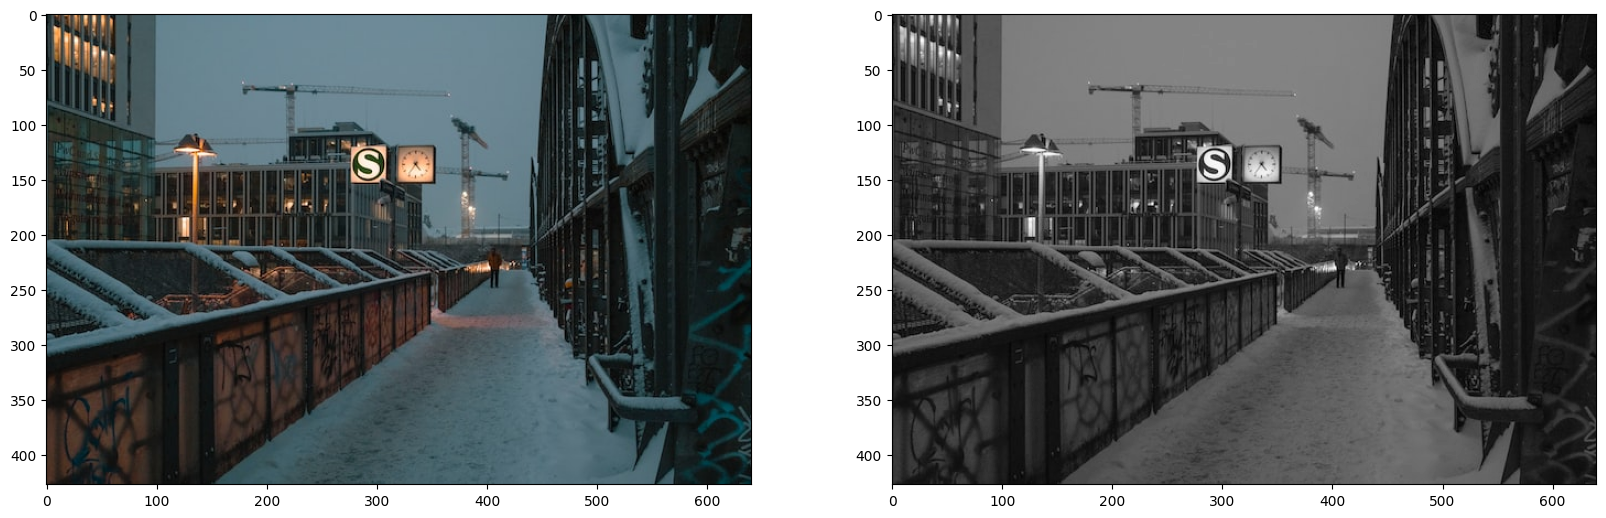

In [62]:
# visualizing image before and after grayscale
image = mpimg.imread(SAMPLE_IMAGE)
gray_image = rgb2gray(image)
img_list = [image, gray_image]

visualize(img_list, 1, 2)


In [63]:
# Step 1: Noise Reduction
# edge detection "canny algorithm" maths are mainly based on gradient calculation (derivatives) so it's highly sensitive to noise,
#  so we apply gaussian filter on the image first, to smooth the image and get rid of noise
# the smallest the kernel, the less visible is the blur.
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


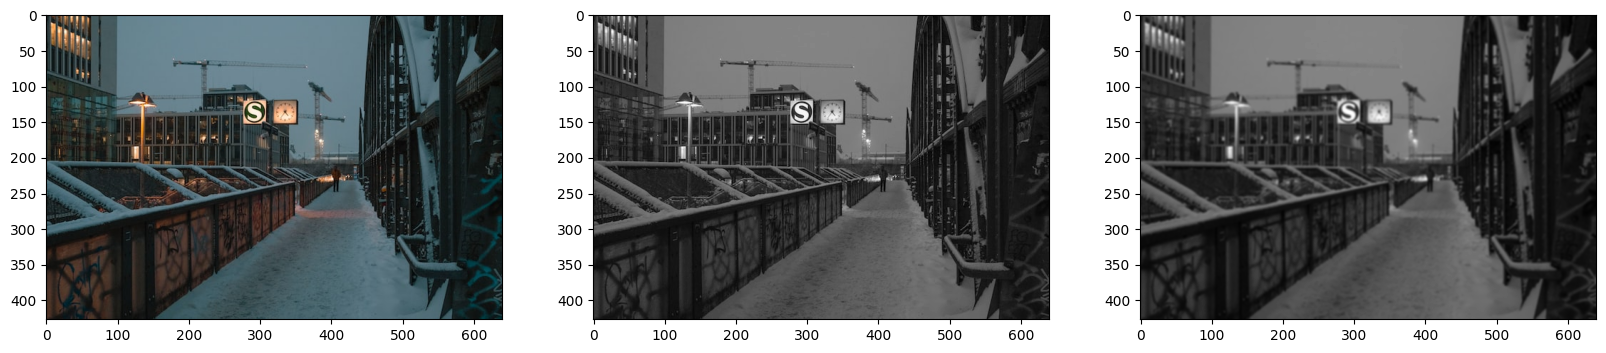

In [64]:
image_blurred = ndimage.convolve(gray_image, gaussian_kernel(5, 1.4))
img_list.append(image_blurred)

visualize(img_list, 1, 3)


In [65]:
# Step 2: Gradient calculation
# detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.
# Edges correspond to a change of pixels’ intensity. To detect it,
# apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)
# derivatives are implemented by convolving I with Sobel kernels Kx and Ky,
def sobel_filters(img):
    Kx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]], dtype=np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
# calculating magnitude G and the slope θ of the gradient
    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)

    return (G, theta)


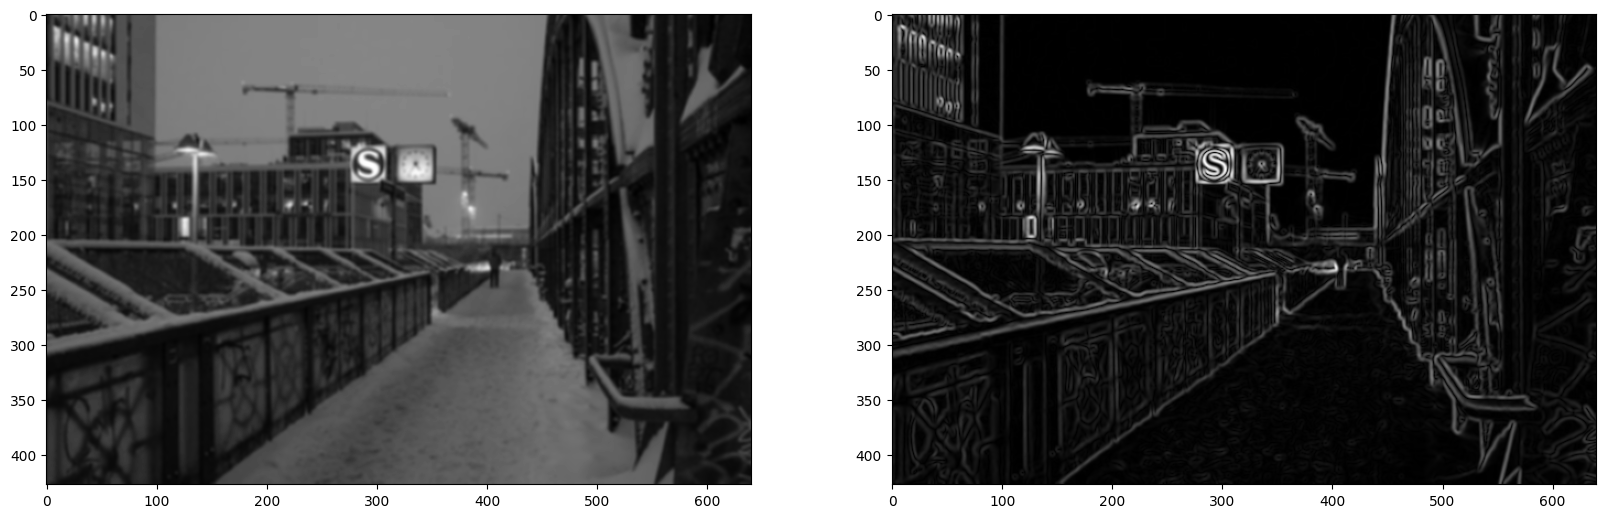

In [66]:
# sobel filter visulaization
gradientMat, thetaMat = sobel_filters(image_blurred)

visualize([image_blurred, gradientMat], 1, 2)


In [67]:
# -----------------  CANNY's FILTER steps------------------------------
# Step 3: Non-maximum suppression
# some of the resulted edges from sobel are thick and others are thin. Non-Max Suppression step will help us
#  mitigate the thick ones.
# the algorithm goes through all the points on the gradient intensity matrix 
# and finds the pixels with the maximum value in the edge directions.
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M):
        for j in range(1, N):
            try:
                q = 255
                r = 255

               # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass
    return Z


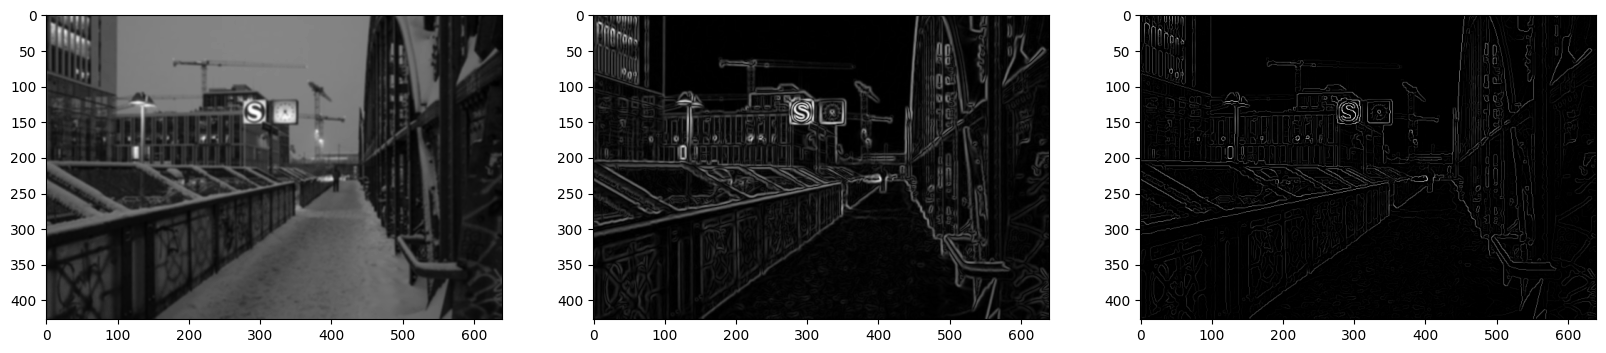

In [68]:
non_max_img = non_max_suppression(gradientMat, thetaMat)
visualize([image_blurred, gradientMat, non_max_img], 1, 3)


In [69]:
# Step 4: Double threshold
# here, we identify 3 types of pixels, strong, weak, and non-relevant
# strong pixels: pixels have high intensity we're sure we are going to keep it in the final edge
# weak pixels: their intensity< strong pixels, we're not sure about their situation
# other pixels than weak & strong pixels are considred non-relevant
# High threshold: for strong pixels
# low threshold: for non-relevant
# pixels that > low AND < high: weak pixels
def threshold(img):
    hiThresh = img.max()*HIGH_THRESHOLD_RATIO
    loThresh = hiThresh * LOW_THRESHOLD_RATIO

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong_i, strong_j = np.where(img >= hiThresh)

    weak_i, weak_j = np.where((img >= loThresh) & (img <= hiThresh))

    res[strong_i, strong_j] = STRONG_PIXEL
    res[weak_i, weak_j] = WEAK_PIXEL

    return res


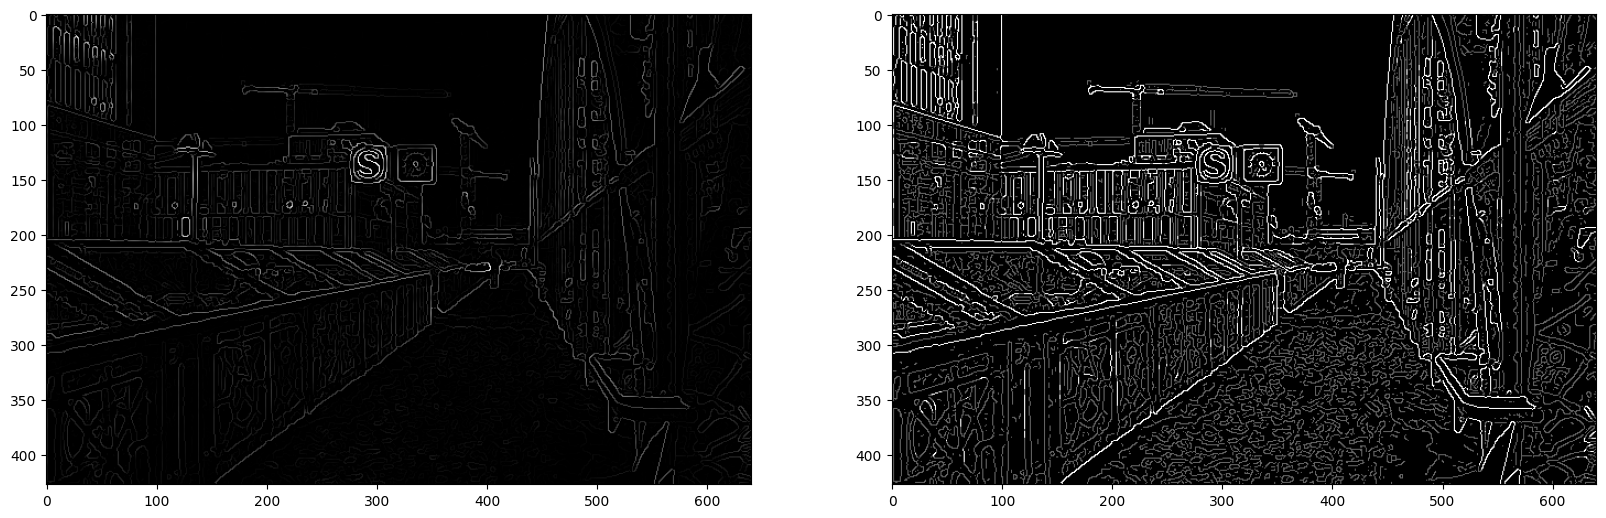

In [70]:
image_thresh = threshold(non_max_img)

visualize([non_max_img, image_thresh], 1, 2)


In [71]:
# Step 5: Edge Tracking by Hysteresis
# transforming weak pixels into strong ones, 
# if and only if at least one of the pixels around the one being processed is a strong one
def hysteresis(img):
    M, N = img.shape

    res = np.copy(img)

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == WEAK_PIXEL):
                try:
                    if (img[i+1, j-1] == STRONG_PIXEL) or (img[i+1, j] == STRONG_PIXEL) or (img[i+1, j+1] == STRONG_PIXEL) or (img[i, j-1] == STRONG_PIXEL) or (img[i, j+1] == STRONG_PIXEL) or (img[i-1, j-1] == STRONG_PIXEL) or (img[i-1, j] == STRONG_PIXEL) or (img[i-1, j+1] == STRONG_PIXEL):
                        res[i, j] = STRONG_PIXEL
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res


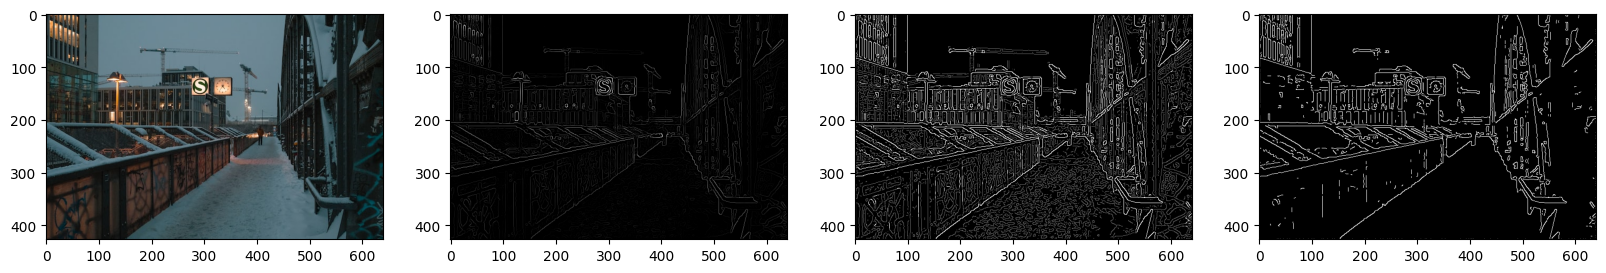

In [72]:
canny_image = hysteresis(image_thresh)
visualize([image, non_max_img, image_thresh, canny_image], 1, 4)


In [73]:
# -----------------_______________ROBERT EDGE DETECTION_______________----------------
def robert_filter(img):
    r_v = np.array( [[ 0, 0, 0 ],
                                [ 0, 1, 0 ],
                                [ 0, 0,-1 ]] )

    r_h = np.array( [[ 0, 0, 0 ],
                                [ 0, 0, 1 ],
                                [ 0,-1, 0 ]] )

    r_y = ndimage.convolve( img, r_v )
    r_x = ndimage.convolve( img, r_h )

    R = np.hypot(r_x, r_y)
    theta_r = np.arctan2(r_x, r_y)
    return (R, theta_r)


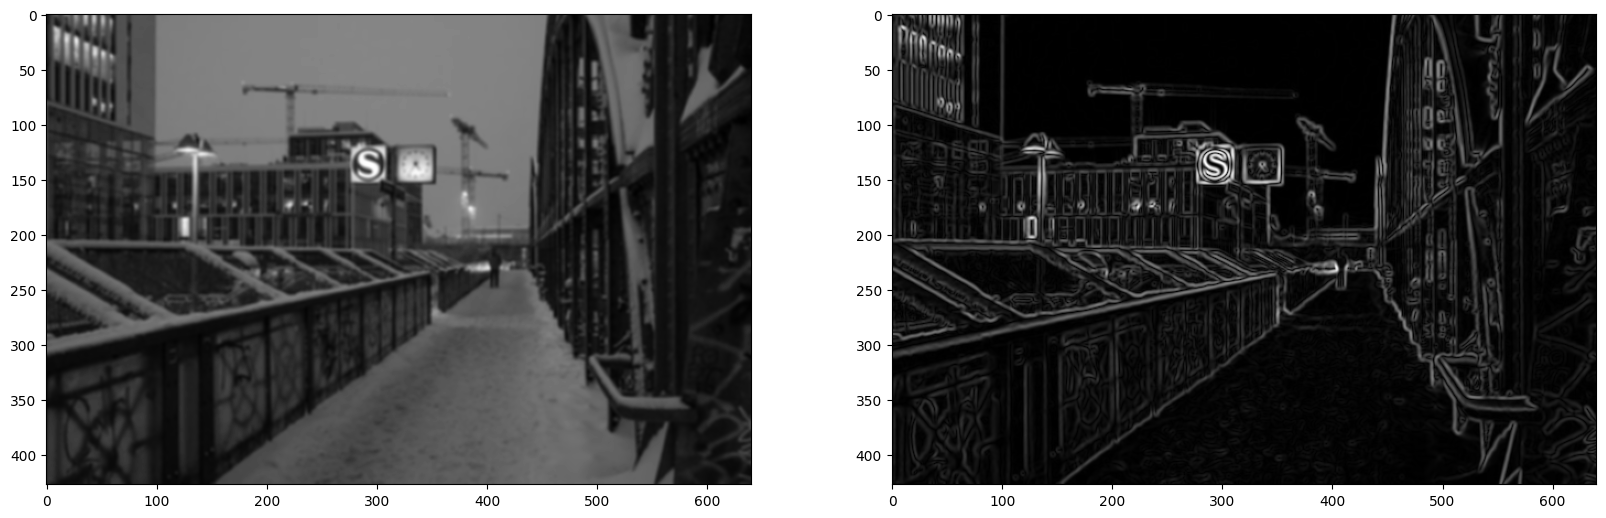

In [74]:
gradientMat, thetaMat = robert_filter(image_blurred)

visualize([image_blurred, gradientMat], 1, 2)


In [75]:

def prewitt_filter(img):
    p_v = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]])

    p_h = np.array([[-1, -1, -1],
                    [0, 0, 0],
                    [1, 1, 1]])

    p_y = ndimage.convolve(img, p_v)
    p_x = ndimage.convolve(img, p_h)

    P = np.hypot(p_x, p_y)
    theta_p = np.arctan2(p_x, p_y)
    return (P, theta_p)


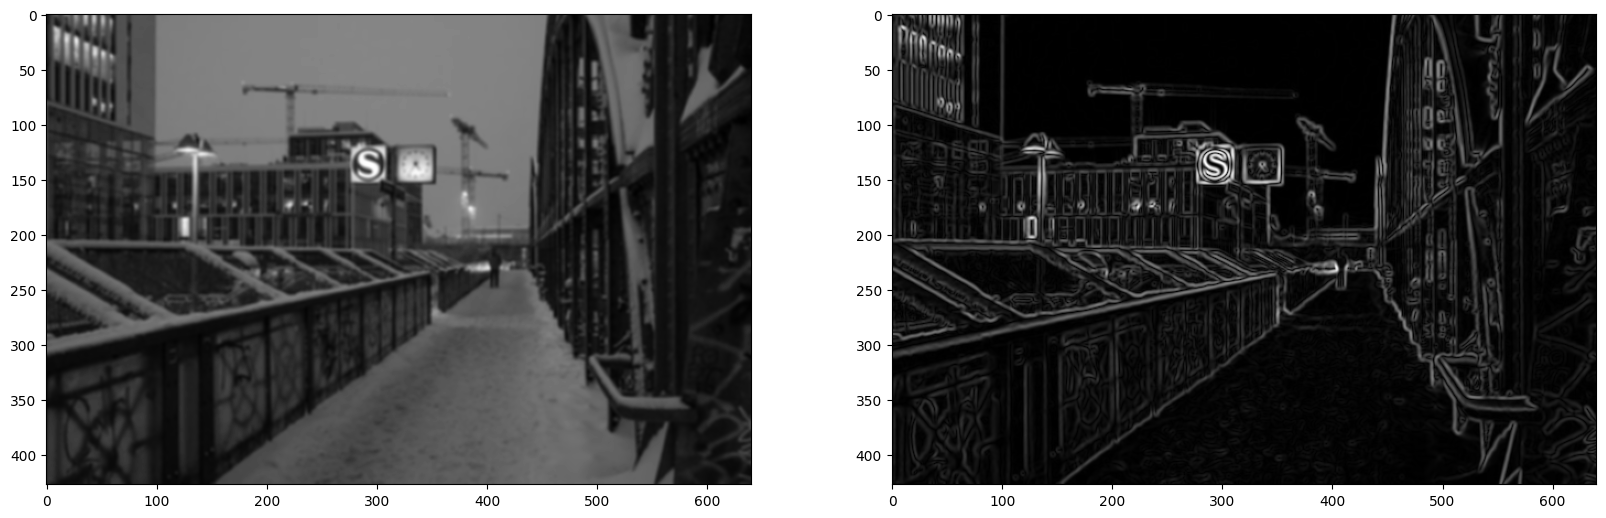

In [76]:
gradientMat, thetaMat = robert_filter(image_blurred)

visualize([image_blurred, gradientMat], 1, 2)


##  sources : <br/>
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123 <br/>
https://www.kaggle.com/code/patrickb1912/canny-edge-detector-from-scratch

